In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [2]:
!pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import textwrap
from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve, precision_score, recall_score
from statistics import mean
from src.utils import utils, evaluation_utils, visualization_utils

In [4]:
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv.csv")
hosts_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv_unseen_hosts.csv")

In [5]:
def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    print(labels_counts)
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n(n={int(v/100*n)}, {v:.3f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [6]:
dataset_df = pd.read_csv(dataset_file_path)

In [7]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=True)
metadata_formatted

Homo sapiens                          218631
Macaca mulatta                           849
Felis catus                              143
Cercocebus atys                          122
Puma concolor                             24
Macaca nemestrina                         23
Mandrillus sphinx                         23
Mandrillus leucophaeus                    20
Cercopithecus nictitans                   19
Cercopithecus solatus                     17
Cercocebus torquatus                      16
Cercopithecus aethiops                    14
Cercopithecus cephus                      13
Chlorocebus sabaeus                       13
Colobus guereza                           13
Panthera leo                              12
Cercopithecus neglectus                   12
Cercopithecus mona                        10
Chlorocebus tantalus                      10
Felis silvestris catus                     9
Cercopithecus lhoesti                      8
Chlorocebus pygerythrus                    7
Cercopithe

{'Homo sapiens': 'Homo sapiens\n(n=218631, 99.347%)',
 'Macaca mulatta': 'Macaca mulatta\n(n=849, 0.386%)',
 'Felis catus': 'Felis catus\n(n=143, 0.065%)',
 'Cercocebus atys': 'Cercocebus atys\n(n=122, 0.055%)',
 'Puma concolor': 'Puma concolor\n(n=24, 0.011%)',
 'Macaca nemestrina': 'Macaca nemestrina\n(n=23, 0.010%)',
 'Mandrillus sphinx': 'Mandrillus sphinx\n(n=23, 0.010%)',
 'Mandrillus leucophaeus': 'Mandrillus leucophaeus\n(n=20, 0.009%)',
 'Cercopithecus nictitans': 'Cercopithecus nictitans\n(n=19, 0.009%)',
 'Cercopithecus solatus': 'Cercopithecus solatus\n(n=17, 0.008%)',
 'Cercocebus torquatus': 'Cercocebus torquatus\n(n=16, 0.007%)',
 'Cercopithecus aethiops': 'Cercopithecus aethiops\n(n=14, 0.006%)',
 'Cercopithecus cephus': 'Cercopithecus cephus\n(n=13, 0.006%)',
 'Chlorocebus sabaeus': 'Chlorocebus sabaeus\n(n=13, 0.006%)',
 'Colobus guereza': 'Colobus guereza\n(n=13, 0.006%)',
 'Panthera leo': 'Panthera leo\n(n=12, 0.005%)',
 'Cercopithecus neglectus': 'Cercopithecus neg

In [8]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=False)
metadata_unformatted

Homo sapiens                          218631
Macaca mulatta                           849
Felis catus                              143
Cercocebus atys                          122
Puma concolor                             24
Macaca nemestrina                         23
Mandrillus sphinx                         23
Mandrillus leucophaeus                    20
Cercopithecus nictitans                   19
Cercopithecus solatus                     17
Cercocebus torquatus                      16
Cercopithecus aethiops                    14
Cercopithecus cephus                      13
Chlorocebus sabaeus                       13
Colobus guereza                           13
Panthera leo                              12
Cercopithecus neglectus                   12
Cercopithecus mona                        10
Chlorocebus tantalus                      10
Felis silvestris catus                     9
Cercopithecus lhoesti                      8
Chlorocebus pygerythrus                    7
Cercopithe

{'Homo sapiens': 99.34702001199629,
 'Macaca mulatta': 0.3857898467746333,
 'Felis catus': 0.0649799152989076,
 'Cercocebus atys': 0.05543741025501209,
 'Puma concolor': 0.010905720050166313,
 'Macaca nemestrina': 0.01045131504807605,
 'Mandrillus sphinx': 0.01045131504807605,
 'Mandrillus leucophaeus': 0.009088100041805259,
 'Cercopithecus nictitans': 0.008633695039714997,
 'Cercopithecus solatus': 0.007724885035534471,
 'Cercocebus torquatus': 0.0072704800334442085,
 'Cercopithecus aethiops': 0.0063616700292636824,
 'Cercopithecus cephus': 0.005907265027173419,
 'Chlorocebus sabaeus': 0.005907265027173419,
 'Colobus guereza': 0.005907265027173419,
 'Panthera leo': 0.005452860025083156,
 'Cercopithecus neglectus': 0.005452860025083156,
 'Cercopithecus mona': 0.0045440500209026295,
 'Chlorocebus tantalus': 0.0045440500209026295,
 'Felis silvestris catus': 0.004089645018812368,
 'Cercopithecus lhoesti': 0.0036352400167221043,
 'Chlorocebus pygerythrus': 0.0031808350146318412,
 'Cercopit

In [9]:
classes = list(metadata_unformatted.keys())
classes

['Homo sapiens',
 'Macaca mulatta',
 'Felis catus',
 'Cercocebus atys',
 'Puma concolor',
 'Macaca nemestrina',
 'Mandrillus sphinx',
 'Mandrillus leucophaeus',
 'Cercopithecus nictitans',
 'Cercopithecus solatus',
 'Cercocebus torquatus',
 'Cercopithecus aethiops',
 'Cercopithecus cephus',
 'Chlorocebus sabaeus',
 'Colobus guereza',
 'Panthera leo',
 'Cercopithecus neglectus',
 'Cercopithecus mona',
 'Chlorocebus tantalus',
 'Felis silvestris catus',
 'Cercopithecus lhoesti',
 'Chlorocebus pygerythrus',
 'Cercopithecus mitis',
 'Cercopithecus erythrotis',
 'Felis domesticus',
 'Macaca arctoides',
 'Macaca fascicularis',
 'Semnopithecus entellus',
 'Bos taurus',
 'Miopithecus ogouensis',
 'Cercopithecus ascanius',
 'Cercocebus torquatus atys',
 'Lynx rufus',
 'Cercopithecus aethiops pygerythrus',
 'Piliocolobus tephrosceles',
 'Piliocolobus badius',
 'Otocolobus manul',
 'Panthera pardus',
 'Papio ursinus',
 'Procolobus verus']

In [10]:
classes_order = {k:i for i, k in enumerate(classes)}
class_formatted_order = {val: classes_order[key] for key, val in metadata_formatted.items()}
print(classes_order)
print(class_formatted_order)

{'Homo sapiens': 0, 'Macaca mulatta': 1, 'Felis catus': 2, 'Cercocebus atys': 3, 'Puma concolor': 4, 'Macaca nemestrina': 5, 'Mandrillus sphinx': 6, 'Mandrillus leucophaeus': 7, 'Cercopithecus nictitans': 8, 'Cercopithecus solatus': 9, 'Cercocebus torquatus': 10, 'Cercopithecus aethiops': 11, 'Cercopithecus cephus': 12, 'Chlorocebus sabaeus': 13, 'Colobus guereza': 14, 'Panthera leo': 15, 'Cercopithecus neglectus': 16, 'Cercopithecus mona': 17, 'Chlorocebus tantalus': 18, 'Felis silvestris catus': 19, 'Cercopithecus lhoesti': 20, 'Chlorocebus pygerythrus': 21, 'Cercopithecus mitis': 22, 'Cercopithecus erythrotis': 23, 'Felis domesticus': 24, 'Macaca arctoides': 25, 'Macaca fascicularis': 26, 'Semnopithecus entellus': 27, 'Bos taurus': 28, 'Miopithecus ogouensis': 29, 'Cercopithecus ascanius': 30, 'Cercocebus torquatus atys': 31, 'Lynx rufus': 32, 'Cercopithecus aethiops pygerythrus': 33, 'Piliocolobus tephrosceles': 34, 'Piliocolobus badius': 35, 'Otocolobus manul': 36, 'Panthera pardu

In [11]:
dataset_df["virus_host_name"].nunique()

40

In [12]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

In [18]:
def get_rank(row, all_output_labels):
    y_true = row["y_true"]
    ranks = row[all_output_labels].rank(ascending=False, method="min")
    return ranks[y_true]

def plot_rank_distribution(df):
    plt.clf()
    plt.figure(figsize=(10, 10))
    sns.set_theme()
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams.update({'font.size': 16})
    ax = sns.displot(df, x="y_true_rank", hue="y_true", kind="kde", fill=True)
    ax.set_xlabel("Rank based on Probability", fontsize=20)
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

   # plt.legend(title="Classes", loc="upper right", fontsize=10)
    plt.show()

    
def plot_probability_distribution(class_prob_df, random_predictor, output_file_path=None):
    n = len(rank_bins)
    color_palette = sns.color_palette("ch:s=.25,rot=-.25_r", n_colors=n)

    random_predictor = 1/19
    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(20, 16), sharey=True)
    sns.set_theme(style="whitegrid")
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams.update({'font.size': 20})
    class_prob_df.sort_values(by="class", key=lambda x: x.map(class_formatted_order), inplace=True)


    sns.stripplot(data=class_prob_df, x="probability", y="class", hue="y_true_rank_bin",
                  palette=color_palette, hue_order=rank_bins, ax=ax[0], legend=False, size=10,
                 linewidth=.2)
    ax[0].axvline(random_predictor, color="gray", linestyle="--", linewidth=2)
    ax[0].set_ylabel("", fontsize=20)
    ax[0].set_xlabel("True Class Probability", fontsize=22)
    ax[0].set_xlim(0, 1)

    barplot_df = pd.crosstab(class_prob_df["class"], class_prob_df["y_true_rank_bin"], normalize="index")[rank_bins].cumsum(axis=1).stack().reset_index().rename(columns={0:"proportion"})
    barplot_df["percent"] = barplot_df["proportion"]*100

    sns.barplot(data=barplot_df, x="percent", y="class", hue="y_true_rank_bin", dodge=False, palette=color_palette[::-1], hue_order=rank_bins[::-1], ax=ax[1])
    ax[1].set_xlabel("Rank Distribution (%)", fontsize=22)

    plt.legend(title="Prediction", loc="upper right", fontsize=22)
    #sns.move_legend(ax[0], "lower center", ncol=6, title=None, bbox_to_anchor=(.9, 1), fontsize=16)
    sns.move_legend(ax[1], "lower center", ncol=6, title=None, bbox_to_anchor=(-0.08, 1), fontsize=16)
    plt.subplots_adjust(wspace = 0.05)
    if output_file_path:
        plt.savefig(output_file_path, bbox_inches="tight")
    plt.show()
    
    
def analyze_all_way_fsl_results(output_file_path, auprc_file_path, hosts_file_path):
    output_auprc_df = pd.read_csv(auprc_file_path, index_col=0)
    output_df = pd.read_csv(output_file_path, index_col=0)
    print(f"Number of unique classes in output_df = {output_auprc_df['class'].nunique()}")
    
    all_output_labels = list(output_df.columns)
    all_output_labels.remove("itr")
    all_output_labels.remove("y_true")
    print(f"Number of unique labels in output_df = {len(all_output_labels)}")
    
    sub_df = output_df[output_df["itr"] == 0]
    sub_df.drop(columns="itr", inplace=True)
    sub_df["y_true_rank"] = sub_df.apply(lambda x: get_rank(x, all_output_labels), axis=1)
    sub_df["y_true_rank_bin"] = sub_df.apply(get_rank_bin, axis=1)
    
    #plot_rank_distribution(sub_df.replace({"y_true": metadata_formatted}))
    
    idv_hosts = set(pd.read_csv(hosts_file_path)["virus_host_name"].unique()).intersection(set(all_output_labels))
    print(f"Number of IDV hosts  - {len(idv_hosts)}")
    print(idv_hosts)
    
    output_df["y_pred"] = output_df[all_output_labels].idxmax(axis=1)
        
    classwise_prob_dfs = []
    
    for label in idv_hosts:
        class_prob_df = sub_df[[label, "y_true", "y_true_rank_bin", "y_true_rank"]][sub_df["y_true"] == label]
        class_prob_df = class_prob_df.rename(columns={label: "probability", "y_true": "class"})
        classwise_prob_dfs.append(class_prob_df)
    class_prob_df = pd.concat(classwise_prob_dfs)
    class_prob_df.replace({"class": metadata_formatted}, inplace=True)
    
    #plot_probability_distribution(class_prob_df, 1/len(all_output_labels))
    return class_prob_df, 1/len(all_output_labels)


### Unseen hosts

#### 167-way

In [14]:
#output_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w3s5q10_ev_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
#auprc_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w3s5q10_ev_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
output_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_all_hosts/20241022/host_multi/few_shot_learning/fsl_tr_w3s5q10_ev_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
auprc_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_all_hosts/20241022/host_multi/few_shot_learning/fsl_tr_w3s5q10_ev_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")


In [19]:
def get_rank_bin(row):
    rank = row["y_true_rank"]
    if rank == 1:
        return "Correct Prediction"
    elif rank <= 5:
        return "Top 5 ranks"
    elif rank <= 10:
        return "Top 10 ranks"
    elif rank <= 15:
        return "Top 15 ranks"
    elif rank <= 20:
        return "Top 20 ranks"
    else:
        return "Rank > 20"
    
rank_bins = ["Correct Prediction", "Top 5 ranks", "Top 10 ranks", "Top 15 ranks", "Top 20 ranks", "Rank > 20"]

In [16]:
class_prob_df, random_predictor= analyze_all_way_fsl_results(output_file_path, auprc_file_path, hosts_file_path)

Number of unique classes in output_df = 167
Number of unique labels in output_df = 167


/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/tmp/ipykernel_2482559/3124518118.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["y_true_rank"] = sub_df.apply(lambda x: get_rank(x, all_output_labels), axis=1)
/tmp/ipykernel_2482559/3124518118.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Number of IDV hosts  - 19
{'Cercopithecus cephus', 'Cercopithecus neglectus', 'Cercopithecus lhoesti', 'Colobus guereza', 'Chlorocebus pygerythrus', 'Puma concolor', 'Felis silvestris catus', 'Macaca nemestrina', 'Cercopithecus nictitans', 'Cercopithecus aethiops', 'Panthera leo', 'Mandrillus leucophaeus', 'Cercocebus torquatus', 'Cercopithecus mitis', 'Cercopithecus solatus', 'Cercopithecus mona', 'Cercocebus atys', 'Chlorocebus tantalus', 'Chlorocebus sabaeus'}


<Figure size 432x288 with 0 Axes>

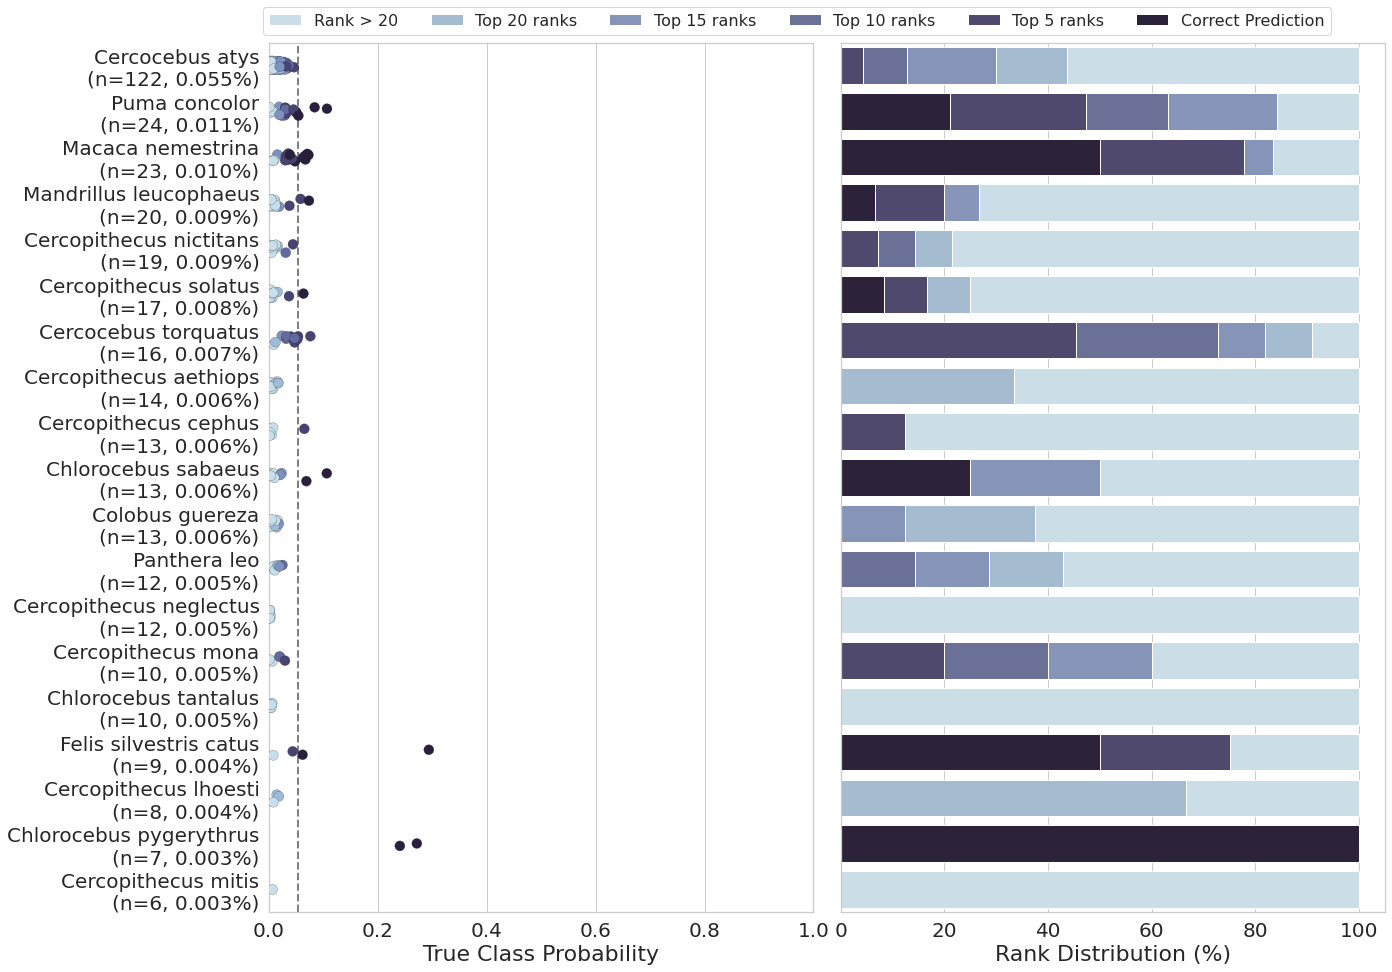

In [21]:
plot_probability_distribution(class_prob_df, random_predictor, output_file_path = os.path.join(os.getcwd(),  "..", "..", "..", f"output/visualization/temp_new/idv_fsl_unseenhosts_167way.pdf"))

#### 24-way

In [22]:
#output_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
#auprc_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
output_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_all_hosts/20241022/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
auprc_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_all_hosts/20241022/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")

In [24]:
def get_rank_bin(row):
    rank = row["y_true_rank"]
    if rank == 1:
        return "Correct Prediction"
    elif rank <= 3:
        return "Top 3 ranks"
    elif rank <= 5:
        return "Top 5 ranks"
    elif rank <= 10:
        return "Top 10 ranks"
    else:
        return "Rank > 10"
    
rank_bins = ["Correct Prediction", "Top 3 ranks", "Top 5 ranks", "Top 10 ranks", "Rank > 10"]
class_prob_df, random_predictor = analyze_all_way_fsl_results(output_file_path, auprc_file_path, hosts_file_path)

Number of unique classes in output_df = 23
Number of unique labels in output_df = 23


/tmp/ipykernel_2482559/3915467608.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["y_true_rank"] = sub_df.apply(lambda x: get_rank(x, all_output_labels), axis=1)
/tmp/ipykernel_2482559/3915467608.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["y_true_rank_bin"] = sub_df.apply(get_rank_bin, axis=1)


Number of IDV hosts  - 19
{'Cercopithecus cephus', 'Cercopithecus neglectus', 'Cercopithecus lhoesti', 'Colobus guereza', 'Chlorocebus pygerythrus', 'Puma concolor', 'Felis silvestris catus', 'Cercopithecus aethiops', 'Cercopithecus nictitans', 'Panthera leo', 'Mandrillus leucophaeus', 'Cercocebus torquatus', 'Cercocebus atys', 'Cercopithecus mitis', 'Cercopithecus mona', 'Cercopithecus solatus', 'Macaca nemestrina', 'Chlorocebus tantalus', 'Chlorocebus sabaeus'}


<Figure size 432x288 with 0 Axes>

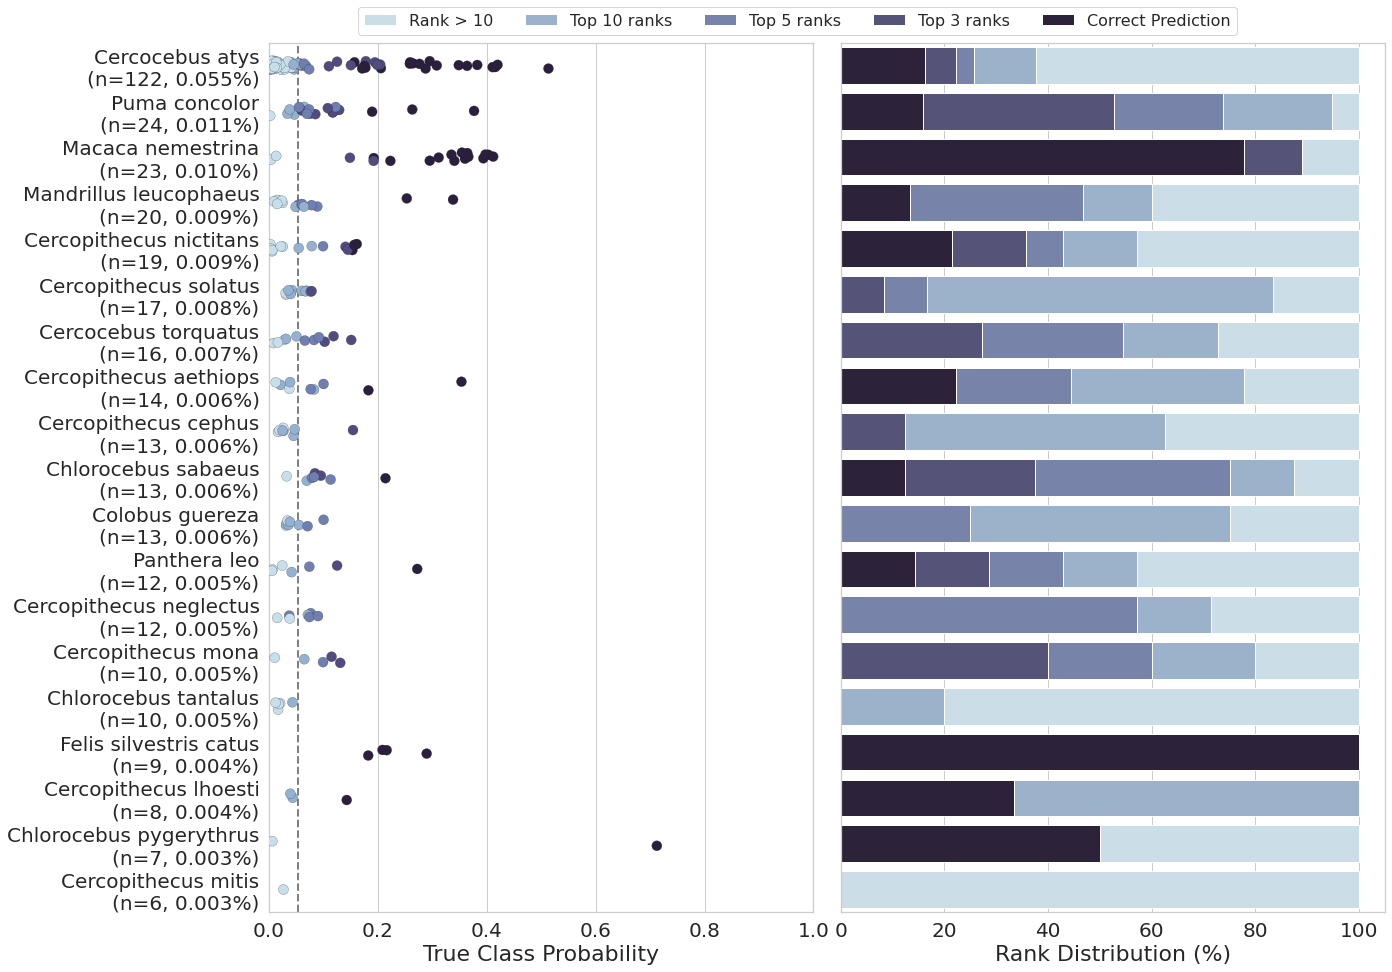

In [25]:
plot_probability_distribution(class_prob_df, random_predictor, output_file_path = os.path.join(os.getcwd(), "..", "..", "..", f"output/visualization/temp_new/idv_fsl_unseenhosts_23way.pdf"))

In [ ]:
barplot_df = pd.crosstab(class_probab_df["class"], class_probab_df["y_true_rank_bin"], normalize="index")[rank_bins].cumsum(axis=1).stack().reset_index().rename(columns={0:"proportion"})
barplot_df["percent"] = barplot_df["proportion"]*100
barplot_df